### LABORATORIO 8

In [28]:
# Importación de paquetes necesarios
from torchvision import transforms, datasets
from IPython.display import display
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import os
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import einops
from torchvision.utils import save_image,make_grid
import glob
from torch.optim import Adam

In [29]:
# Definición de hiperparámetros y configuraciones
BATCH_SIZE = 128
IMG_SIZE = 28
CHANNEL = 1
EPOCH = 200
SIZE = 20
lr = 0.0001
MODEL_DIR = 'model_weight'
root_train = 'comics-celebs'

# Crear el directorio para guardar los modelos si no existe
save_dir = os.path.join(MODEL_DIR)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [30]:
# Verificar versiones de Torch y CUDA y seleccionar dispositivo
print(torch.__version__)
print(torch.version.cuda)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

2.2.2
12.1


## Construyendo el Modelo de Difusión
Primero necesitamos construir las entradas para nuestro modelo, que son imágenes cada vez más ruidosas. En lugar de hacer esto secuencialmente, podemos usar la forma cerrada proporcionada en los documentos para calcular la imagen para cualquiera de los pasos de tiempo individualmente.### 

Puntos Cl:
e:
Los niveles de ruido/varianzas pueden precomput.arse
Hay diferentes tipos de programas de var.ianza
Podemos muestrear cada imagen de paso de tiempo de forma independiente (Sumas de Gaussianos también es Gaus.siano)
No se necesita un modelo en este paso hacia a.
$$
q( x_t | x_0 ) = N( x_t; \sqrt{{\alpha}_t}x_t, (1-{\alpha}_t)I )
$$
​
 ; 
α 
t
​
 
​
 x 
t
​
 ,(1−α 
t
​
 )I)

In [31]:
class DDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(DDPM, self).__init__()
        self.n_steps = n_steps  # Número de pasos de difusión
        self.device = device  # Dispositivo (CPU o GPU)
        self.image_chw = image_chw  # Dimensiones de la imagen
        self.network = network.to(device)  # Red neuronal subyacente
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)  # Parámetros de ruido
        self.alphas = 1 - self.betas  # Coeficientes de ruido
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)
        # Pre-cálculo de productos acumulativos de alphas

    def forward(self, x0, t, eta=None):
        # Agregar ruido a la imagen de entrada en un paso de tiempo t dado
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]  # Obtener alpha_bar correspondiente a t

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)  # Generar ruido aleatorio si no se proporciona

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy  # Imagen ruidosa generada

    def backward(self, x, t):
        # Pasar la imagen ruidosa a través de la red para estimar el ruido
        return self.network(x, t)


## Funciones para Mostrar Imágenes

In [32]:
def show_tensor_image(image, save, idx=0):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW a HWC
    ])

    # Tomar la primera imagen del lote
    if len(image.shape) == 4:
        image = image[idx, :, :, :]
    if save == False:
        plt.imshow(reverse_transforms(image), cmap="gray")
        return image
    else:
        return image

def show_forward(ddpm, loader, device):
    # Mostrar el proceso hacia adelante
    for batch in loader:
        imgs = batch
        num_images = 6
        idx = 0
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        for percent in [0.0, 0.2, 0.4, 0.6, 0.8, 1]:
            plt.subplot(1, num_images + 1, idx + 1)
            if percent == 0.0:
                show_tensor_image(imgs, False)
            else:
                show_tensor_image(ddpm(imgs.to(device),
                    [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]).detach().cpu(), False)
            idx += 1
        break
    plt.show()

def generate_new_images(ddpm, n_samples=16, device=None, c=1, h=28, w=28, process=False):
    """Dado un modelo DDPM, un número de muestras a generar y un dispositivo, devuelve algunas muestras recién generadas"""
    images = []
    with torch.no_grad():
        if device is None:
            device = ddpm.device

        if process == True:
            tmp = torch.zeros((n_samples, c, h, w), dtype=torch.float32).to(device)
            images = tmp.detach().cpu()

        # Comenzando desde el ruido aleatorio
        x = torch.randn(n_samples, c, h, w).to(device)
        steps = int(ddpm.n_steps / 6)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimación del ruido a eliminar
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Desruidos parcialmente la imagen
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Agregar algo más de ruido como en la moda de Dinámica de Langevin
                x = x + sigma_t * z
            if process and (idx == 0 or (idx + 1) % steps == 0):
                images = torch.cat((images, x.detach().cpu()), 0)
        if process:
            return images

    return x


## Cargar dataset


In [33]:
train_data = []  # Lista para almacenar los datos de entrenamiento

# Transformaciones a aplicar a las imágenes
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Redimensionar las imágenes a 28x28 píxeles
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) * 2)  # Normalizar los valores de píxeles en el rango [-1, 1]
])

# Directorio principal que contiene las subcarpetas 'comics' y 'celebs'
main_directory = "comics-celebs"

# Iterar sobre las subcarpetas dentro del directorio principal
for subfolder in ["comics", "celebs"]:
    subfolder_path = os.path.join(main_directory, subfolder)  # Ruta de la subcarpeta actual

    # Iterar sobre todos los archivos de imagen con extensión ".jpg" dentro de la subcarpeta actual
    for im_path in glob.glob(os.path.join(subfolder_path, '*.jpg')):
        # Aplicar las transformaciones a la imagen y agregarla a la lista de datos de entrenamiento
        train_data.append(transform(Image.open(im_path)))

# Imprimir el número total de imágenes cargadas
print("Total de imágenes cargadas:", len(train_data))


Total de imágenes cargadas: 19998


In [34]:
# Crear el DataLoader para los datos de entrenamiento
data_loader = DataLoader( train_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True )

In [35]:
print(train_data[0].shape)

torch.Size([1, 28, 28])


In [39]:
# Función para generar incrustaciones sinusoidales para los tiempos
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [40]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(Block, self).__init__()
        
        # Inicialización de capas
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.ReLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        if self.normalize:
            out = self.ln(x)
        else:
            out = x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out


In [41]:
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100, image_channels=1):
        super(UNet, self).__init__()
        down_channels = (image_channels,16, 32, 64)
        up_channels = (128 ,64, 32, 16)
        size = (28, 14, 7)
        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, down_channels[0])
        self.b1 = self._make_conv(down_channels[0], down_channels[1] ,down_channels[1], size[0] )
        self.down1 = nn.Conv2d(down_channels[1], down_channels[1], 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, down_channels[1])
        self.b2 = self._make_conv(down_channels[1], down_channels[2] ,down_channels[2], size[1] )
        self.down2 = nn.Conv2d(down_channels[2], down_channels[2], 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, down_channels[2])
        self.b3 = self._make_conv(down_channels[2], down_channels[3] ,down_channels[3], size[2] )
        self.down3 = nn.Sequential(
            nn.Conv2d(down_channels[3], down_channels[3], 2, 1),
            nn.ReLU(),
            nn.Conv2d(down_channels[3], down_channels[3], 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, down_channels[3])
        self.b_mid = nn.Sequential(
            Block((down_channels[3], 3, 3), down_channels[3], down_channels[2]),
            Block((down_channels[2], 3, 3), down_channels[2], down_channels[2]),
            Block((down_channels[2], 3, 3), down_channels[2], down_channels[3])
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(down_channels[3], down_channels[3], 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(down_channels[3], down_channels[3], 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, up_channels[0])
        self.b4 = self._make_conv(up_channels[0], up_channels[1] ,up_channels[2], size[2] )

        self.up2 = nn.ConvTranspose2d(up_channels[2], up_channels[2], 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, up_channels[1])
        self.b5 = self._make_conv(up_channels[1], up_channels[2] ,up_channels[3], size[1] )

        self.up3 = nn.ConvTranspose2d(up_channels[3], up_channels[3], 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, up_channels[2])
        self.b_out = self._make_conv(up_channels[2], up_channels[3] ,up_channels[3], size[0] )
        self.conv_out = nn.Conv2d(up_channels[3], 1, 3, 1, 1)

    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 16, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 32, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 64, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 64, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 128, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 32, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 64, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 16, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 32, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)
        out = self.conv_out(out)
        #print('Network:',out.shape)
        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.ReLU(),
            nn.Linear(dim_out, dim_out)
        )

    def _make_conv(self, in_c, mid_c, out_c, size, normalize=True ):
        return nn.Sequential(
            Block((in_c, size, size), in_c, mid_c),
            Block((mid_c, size, size), mid_c, out_c),
            Block((out_c, size, size), out_c, out_c,normalize=normalize)
        )
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
model = DDPM(UNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device).to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  1213704


DDPM(
  (network): UNet(
    (time_embed): Embedding(1000, 100)
    (te1): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1, out_features=1, bias=True)
    )
    (b1): Sequential(
      (0): Block(
        (ln): LayerNorm((1, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Block(
        (ln): LayerNorm((16, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Block(
        (ln): LayerNorm((16, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1)

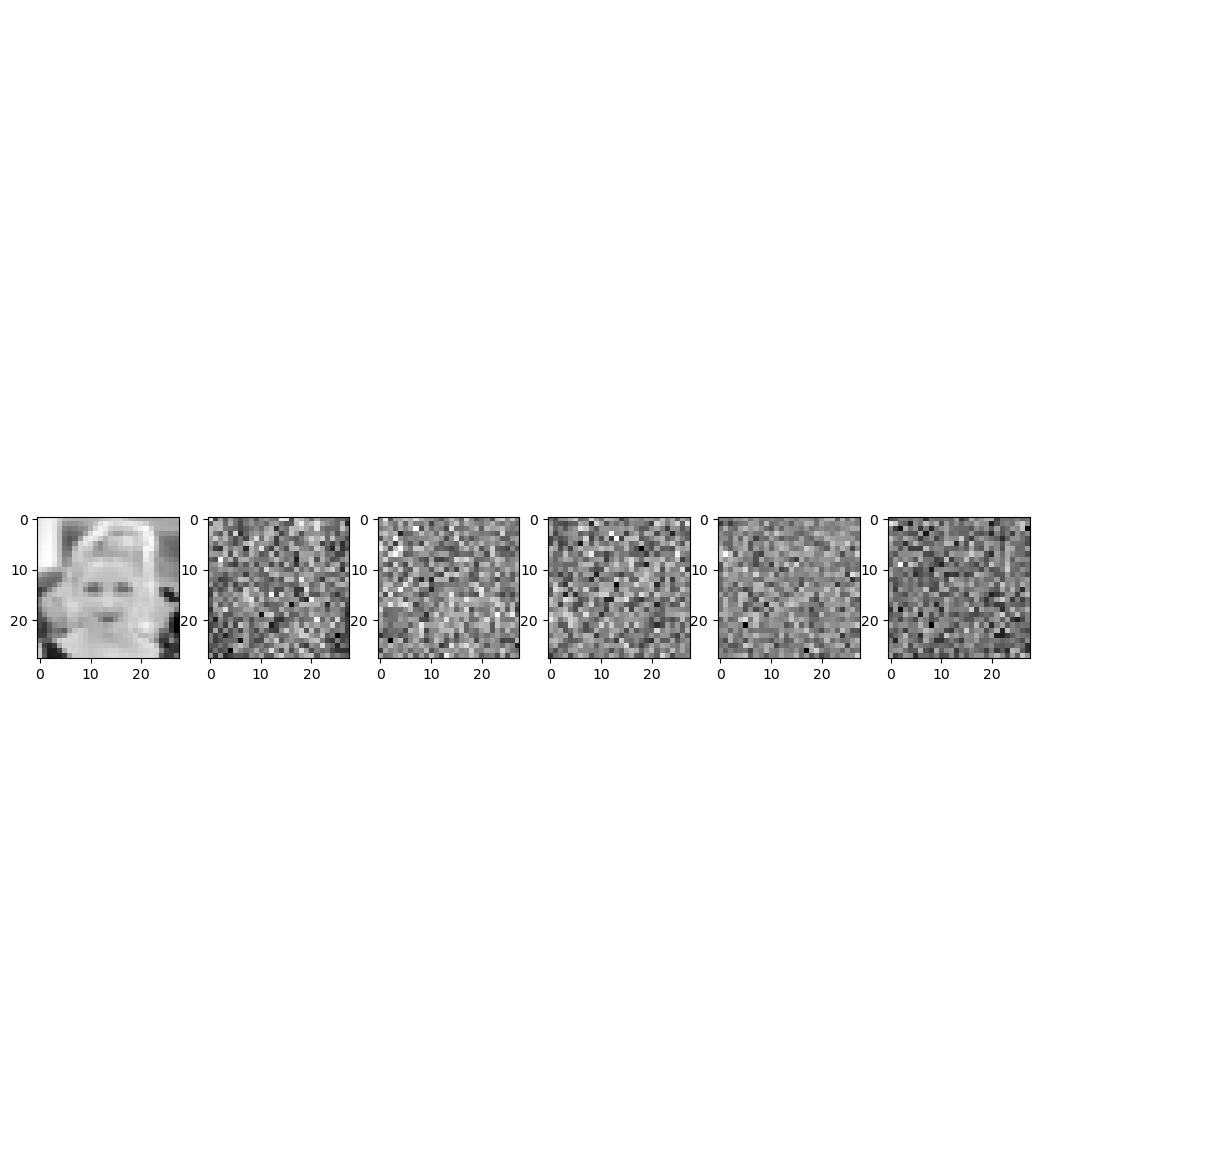

In [42]:
# Recorrer el conjunto de datos en el cargador de datos (data_loader)
# `data_loader` es probablemente un DataLoader que proporciona lotes de datos para la difusión
#for step, batch in enumerate(data_loader):
    # Llamar a la función `show_forward` con el modelo y el cargador de datos
show_forward(model, data_loader, device)


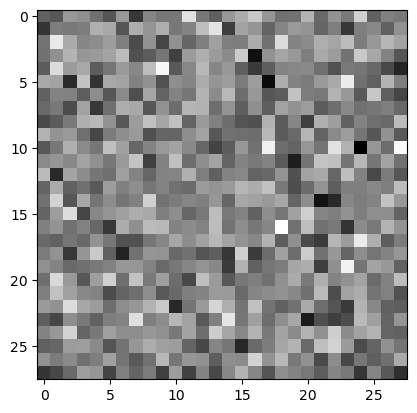

In [43]:
# Generar nuevas imágenes utilizando el modelo
generated = generate_new_images(model, n_samples=1)

# Mostrar la imagen generada
# La función `show_tensor_image` probablemente convierte el tensor de imagen en un formato adecuado para visualización
# El argumento `False` probablemente controla si se debe mostrar o no la imagen
img = show_tensor_image(generated.detach().cpu(), False)


Epoch 0 | step 155 Loss: 0.21599942445755005 


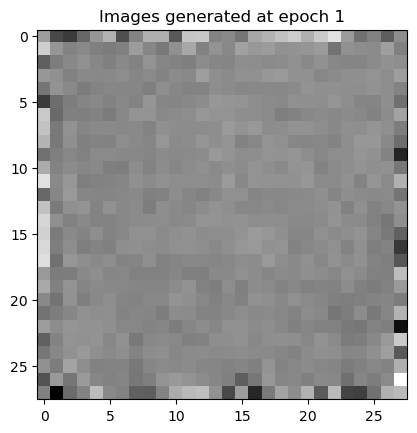

Loss at epoch 1: 0.001 --> Best model ever (stored)
Loss at epoch 2: 0.001 --> Best model ever (stored)
Loss at epoch 3: 0.001 --> Best model ever (stored)
Loss at epoch 4: 0.001 --> Best model ever (stored)
Loss at epoch 5: 0.001 --> Best model ever (stored)
Epoch 5 | step 155 Loss: 0.06685288995504379 


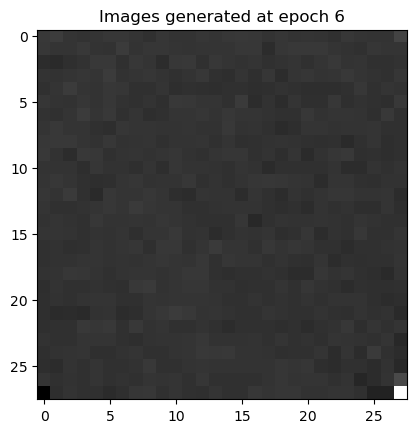

Loss at epoch 6: 0.000 --> Best model ever (stored)
Loss at epoch 7: 0.000
Loss at epoch 8: 0.001
Loss at epoch 9: 0.000
Loss at epoch 10: 0.000 --> Best model ever (stored)
Epoch 10 | step 155 Loss: 0.07982002943754196 


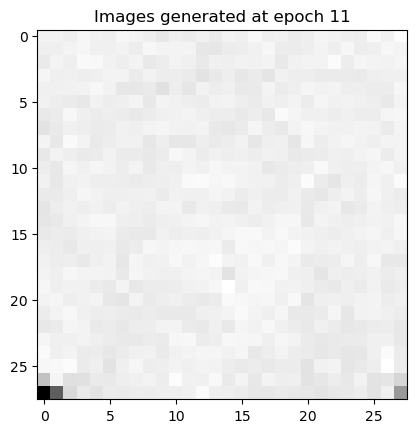

Loss at epoch 11: 0.001
Loss at epoch 12: 0.000
Loss at epoch 13: 0.001
Loss at epoch 14: 0.000
Loss at epoch 15: 0.001
Epoch 15 | step 155 Loss: 0.06947696208953857 


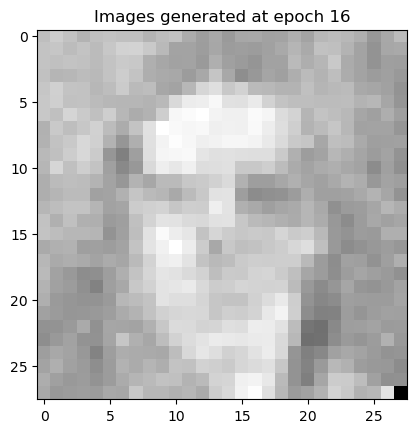

Loss at epoch 16: 0.000
Loss at epoch 17: 0.000
Loss at epoch 18: 0.000
Loss at epoch 19: 0.000
Loss at epoch 20: 0.000
Epoch 20 | step 155 Loss: 0.07301270216703415 


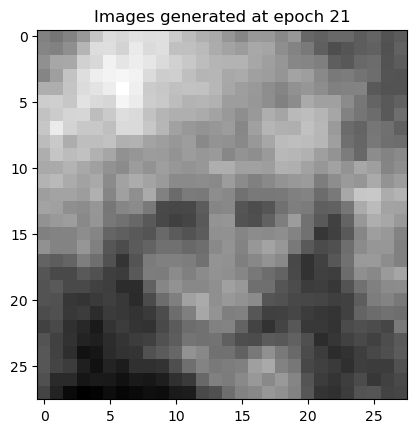

Loss at epoch 21: 0.000
Loss at epoch 22: 0.000
Loss at epoch 23: 0.000
Loss at epoch 24: 0.000
Loss at epoch 25: 0.001
Epoch 25 | step 155 Loss: 0.07301810383796692 


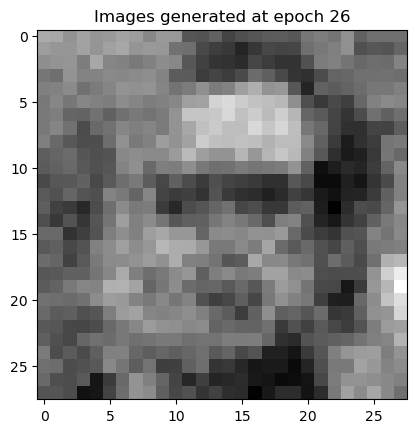

Loss at epoch 26: 0.000
Loss at epoch 27: 0.000
Loss at epoch 28: 0.000
Loss at epoch 29: 0.000
Loss at epoch 30: 0.000
Epoch 30 | step 155 Loss: 0.05068677291274071 


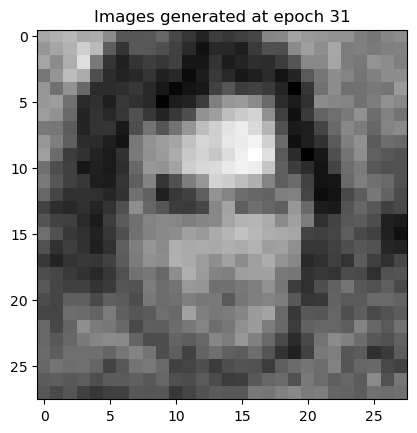

Loss at epoch 31: 0.000
Loss at epoch 32: 0.000
Loss at epoch 33: 0.000
Loss at epoch 34: 0.000
Loss at epoch 35: 0.000
Epoch 35 | step 155 Loss: 0.06365197896957397 


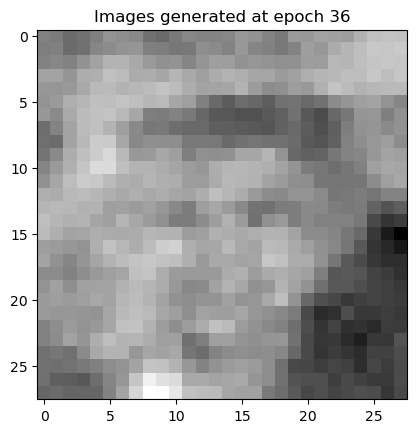

Loss at epoch 36: 0.000
Loss at epoch 37: 0.000
Loss at epoch 38: 0.000 --> Best model ever (stored)
Loss at epoch 39: 0.000
Loss at epoch 40: 0.000
Epoch 40 | step 155 Loss: 0.058897845447063446 


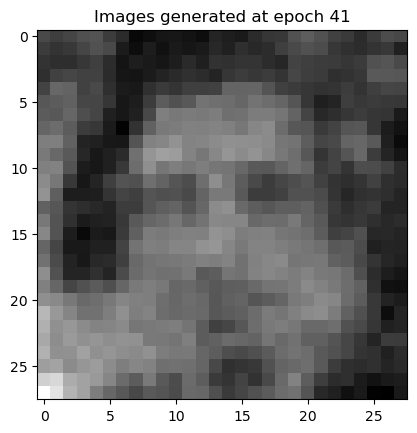

Loss at epoch 41: 0.000
Loss at epoch 42: 0.000
Loss at epoch 43: 0.000
Loss at epoch 44: 0.000
Loss at epoch 45: 0.000
Epoch 45 | step 155 Loss: 0.0690026730298996 


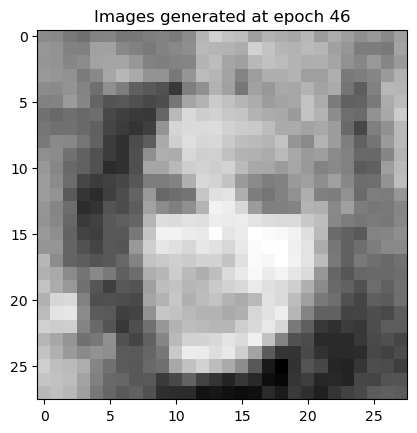

Loss at epoch 46: 0.000
Loss at epoch 47: 0.000
Loss at epoch 48: 0.000
Loss at epoch 49: 0.001
Loss at epoch 50: 0.000
Epoch 50 | step 155 Loss: 0.08361156284809113 


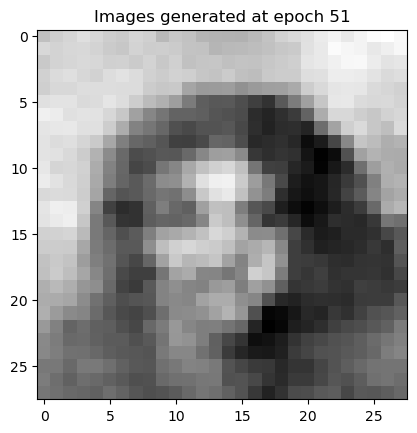

Loss at epoch 51: 0.001
Loss at epoch 52: 0.000
Loss at epoch 53: 0.000
Loss at epoch 54: 0.000
Loss at epoch 55: 0.000
Epoch 55 | step 155 Loss: 0.05153194069862366 


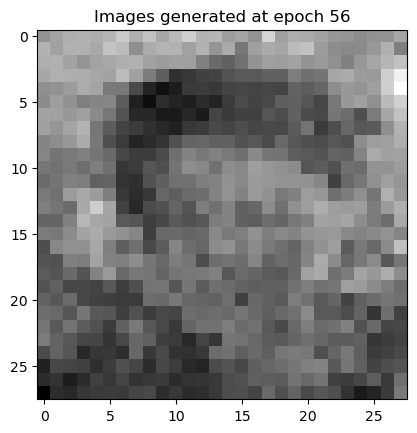

Loss at epoch 56: 0.000
Loss at epoch 57: 0.000 --> Best model ever (stored)
Loss at epoch 58: 0.000
Loss at epoch 59: 0.000
Loss at epoch 60: 0.001
Epoch 60 | step 155 Loss: 0.06911099702119827 


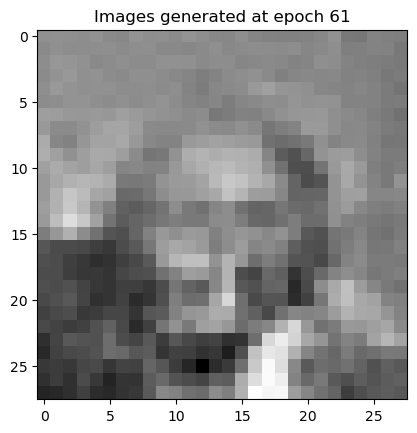

Loss at epoch 61: 0.000
Loss at epoch 62: 0.000
Loss at epoch 63: 0.001
Loss at epoch 64: 0.000 --> Best model ever (stored)
Loss at epoch 65: 0.000
Epoch 65 | step 155 Loss: 0.058957021683454514 


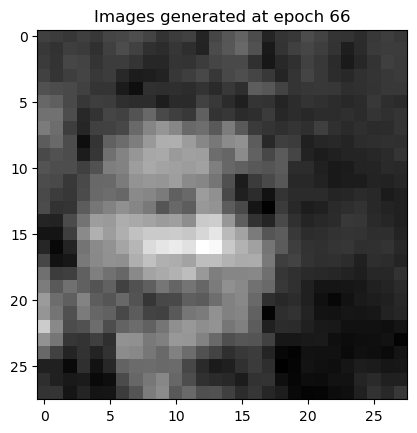

Loss at epoch 66: 0.000
Loss at epoch 67: 0.000
Loss at epoch 68: 0.000
Loss at epoch 69: 0.000
Loss at epoch 70: 0.000
Epoch 70 | step 155 Loss: 0.08546626567840576 


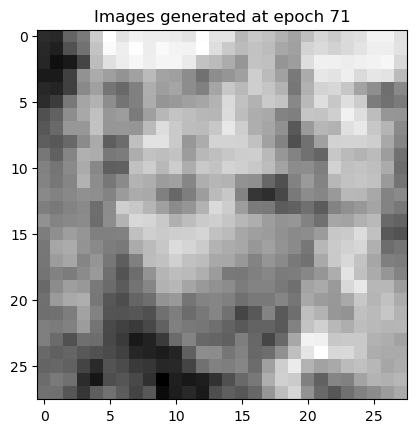

Loss at epoch 71: 0.001
Loss at epoch 72: 0.000
Loss at epoch 73: 0.000
Loss at epoch 74: 0.000
Loss at epoch 75: 0.000
Epoch 75 | step 155 Loss: 0.0623726062476635 


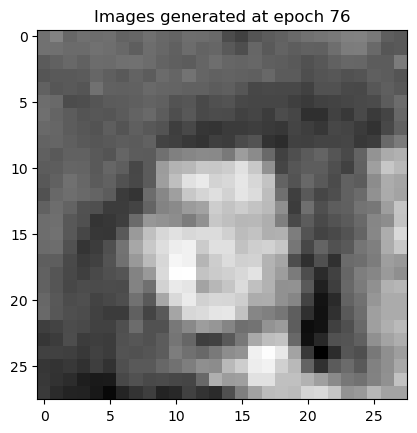

Loss at epoch 76: 0.000
Loss at epoch 77: 0.000
Loss at epoch 78: 0.000
Loss at epoch 79: 0.000
Loss at epoch 80: 0.000
Epoch 80 | step 155 Loss: 0.046718038618564606 


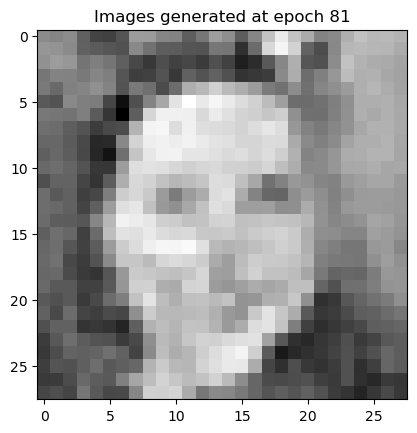

Loss at epoch 81: 0.000
Loss at epoch 82: 0.000
Loss at epoch 83: 0.000
Loss at epoch 84: 0.000
Loss at epoch 85: 0.000
Epoch 85 | step 155 Loss: 0.058205798268318176 


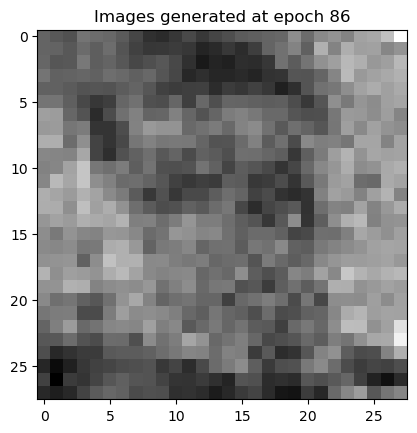

Loss at epoch 86: 0.000
Loss at epoch 87: 0.000
Loss at epoch 88: 0.000
Loss at epoch 89: 0.000
Loss at epoch 90: 0.000
Epoch 90 | step 155 Loss: 0.04919195920228958 


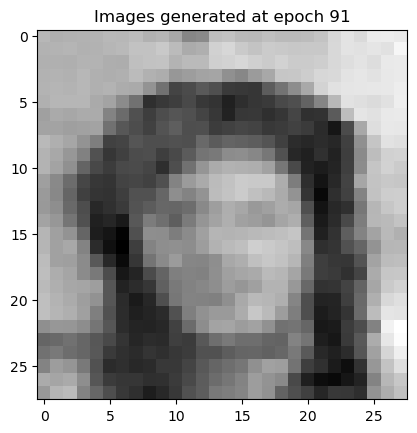

Loss at epoch 91: 0.000
Loss at epoch 92: 0.000
Loss at epoch 93: 0.000
Loss at epoch 94: 0.000
Loss at epoch 95: 0.000
Epoch 95 | step 155 Loss: 0.06252657622098923 


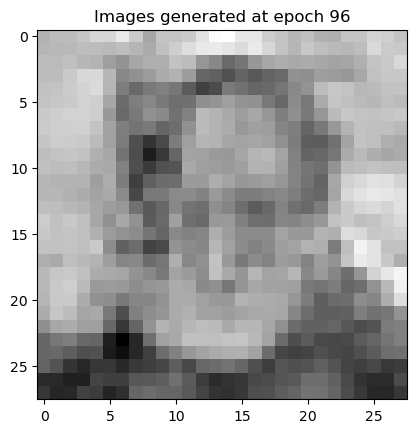

Loss at epoch 96: 0.000
Loss at epoch 97: 0.000
Loss at epoch 98: 0.000
Loss at epoch 99: 0.000
Loss at epoch 100: 0.000
Epoch 100 | step 155 Loss: 0.05212349072098732 


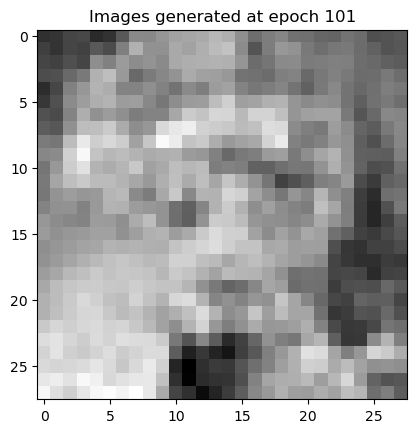

Loss at epoch 101: 0.000
Loss at epoch 102: 0.000
Loss at epoch 103: 0.000
Loss at epoch 104: 0.000
Loss at epoch 105: 0.000
Epoch 105 | step 155 Loss: 0.052137795835733414 


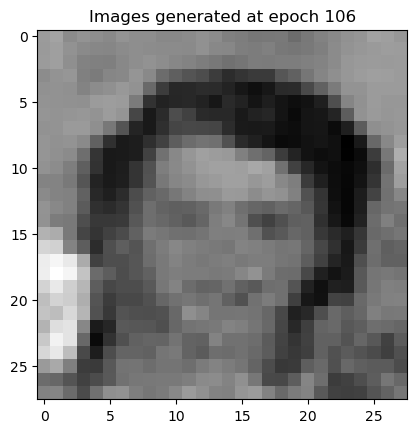

Loss at epoch 106: 0.000
Loss at epoch 107: 0.000
Loss at epoch 108: 0.000
Loss at epoch 109: 0.000
Loss at epoch 110: 0.000
Epoch 110 | step 155 Loss: 0.04786968603730202 


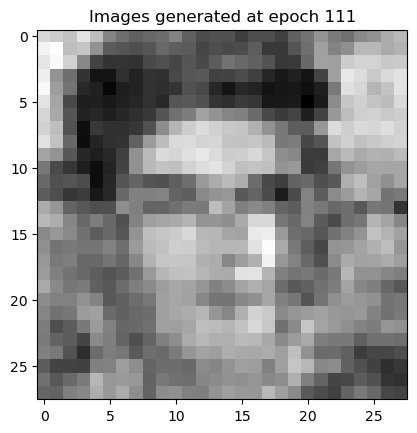

Loss at epoch 111: 0.000
Loss at epoch 112: 0.000
Loss at epoch 113: 0.000
Loss at epoch 114: 0.000
Loss at epoch 115: 0.000
Epoch 115 | step 155 Loss: 0.04751918837428093 


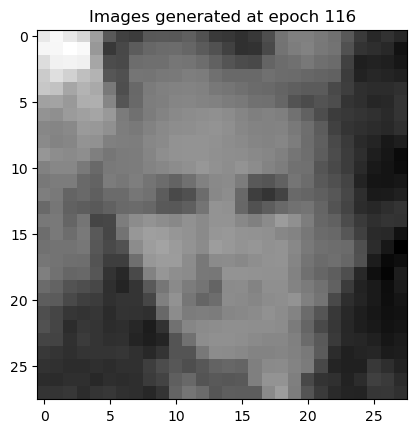

Loss at epoch 116: 0.000
Loss at epoch 117: 0.000
Loss at epoch 118: 0.000
Loss at epoch 119: 0.000
Loss at epoch 120: 0.000
Epoch 120 | step 155 Loss: 0.056204650551080704 


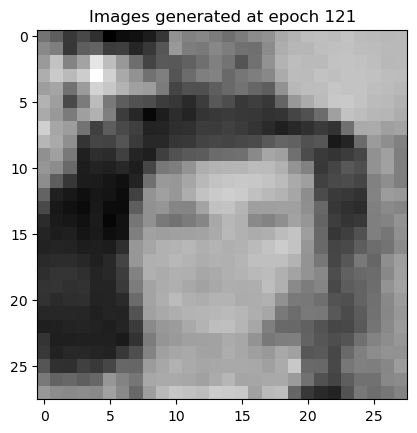

Loss at epoch 121: 0.000
Loss at epoch 122: 0.000
Loss at epoch 123: 0.000
Loss at epoch 124: 0.000
Loss at epoch 125: 0.000
Epoch 125 | step 155 Loss: 0.04991619661450386 


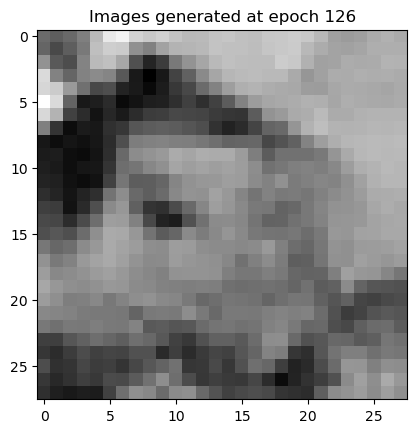

Loss at epoch 126: 0.000
Loss at epoch 127: 0.000
Loss at epoch 128: 0.000
Loss at epoch 129: 0.000
Loss at epoch 130: 0.000
Epoch 130 | step 155 Loss: 0.04568193852901459 


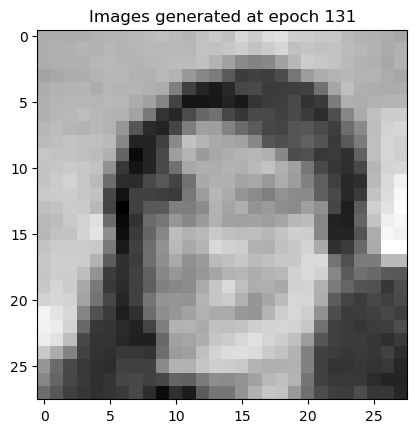

Loss at epoch 131: 0.000
Loss at epoch 132: 0.000
Loss at epoch 133: 0.000
Loss at epoch 134: 0.000
Loss at epoch 135: 0.000
Epoch 135 | step 155 Loss: 0.05926699936389923 


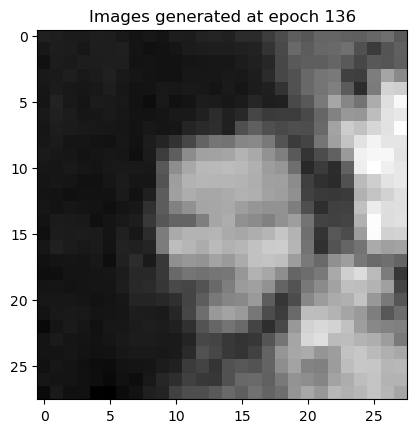

Loss at epoch 136: 0.000
Loss at epoch 137: 0.000
Loss at epoch 138: 0.000
Loss at epoch 139: 0.000
Loss at epoch 140: 0.000
Epoch 140 | step 155 Loss: 0.0449049174785614 


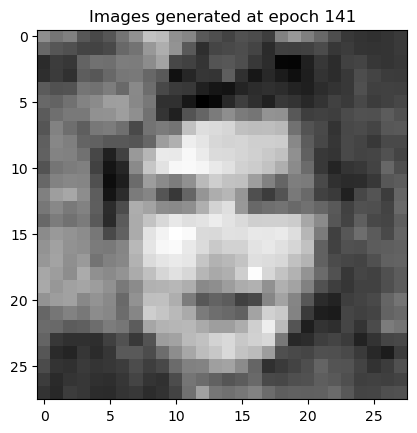

Loss at epoch 141: 0.000
Loss at epoch 142: 0.000
Loss at epoch 143: 0.000
Loss at epoch 144: 0.000
Loss at epoch 145: 0.000
Epoch 145 | step 155 Loss: 0.050037384033203125 


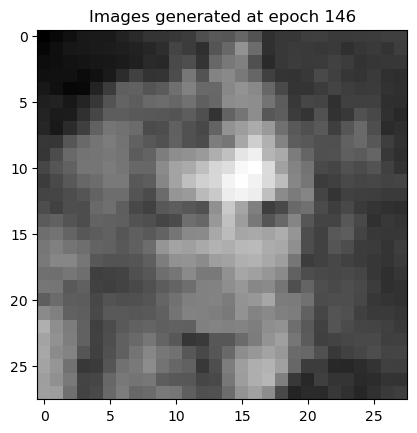

Loss at epoch 146: 0.000
Loss at epoch 147: 0.000
Loss at epoch 148: 0.000
Loss at epoch 149: 0.000
Loss at epoch 150: 0.000
Epoch 150 | step 155 Loss: 0.05070699006319046 


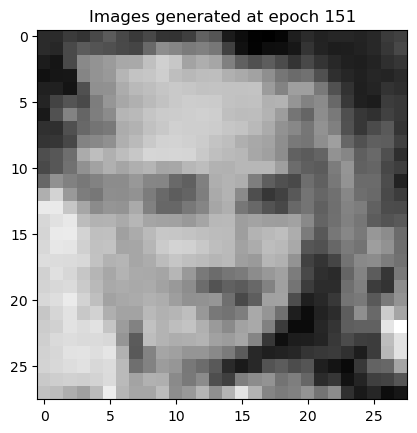

Loss at epoch 151: 0.000
Loss at epoch 152: 0.000
Loss at epoch 153: 0.000 --> Best model ever (stored)
Loss at epoch 154: 0.000
Loss at epoch 155: 0.000
Epoch 155 | step 155 Loss: 0.05967501178383827 


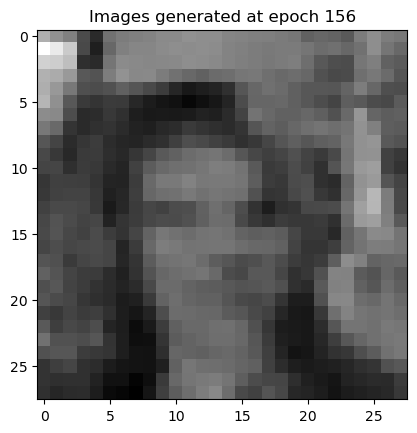

Loss at epoch 156: 0.000
Loss at epoch 157: 0.000
Loss at epoch 158: 0.000
Loss at epoch 159: 0.000
Loss at epoch 160: 0.000
Epoch 160 | step 155 Loss: 0.03772249072790146 


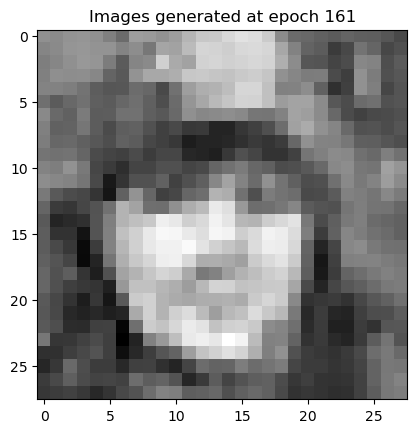

Loss at epoch 161: 0.000
Loss at epoch 162: 0.000
Loss at epoch 163: 0.000
Loss at epoch 164: 0.000
Loss at epoch 165: 0.000
Epoch 165 | step 155 Loss: 0.06501159071922302 


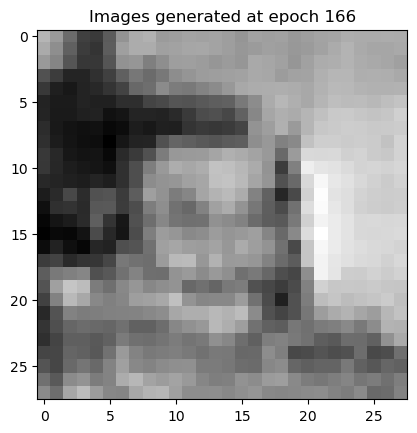

Loss at epoch 166: 0.000
Loss at epoch 167: 0.000
Loss at epoch 168: 0.000
Loss at epoch 169: 0.000
Loss at epoch 170: 0.000
Epoch 170 | step 155 Loss: 0.05244867876172066 


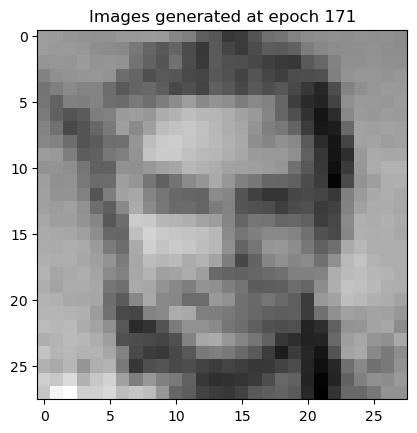

Loss at epoch 171: 0.000
Loss at epoch 172: 0.000
Loss at epoch 173: 0.000
Loss at epoch 174: 0.000
Loss at epoch 175: 0.000
Epoch 175 | step 155 Loss: 0.058058541268110275 


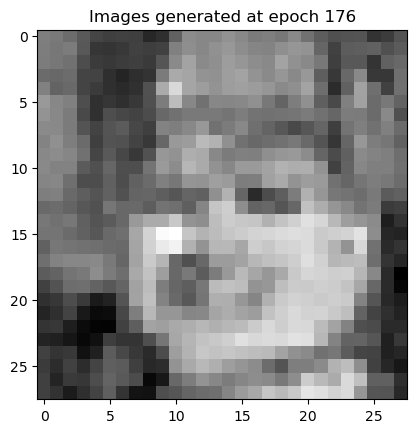

Loss at epoch 176: 0.000
Loss at epoch 177: 0.000
Loss at epoch 178: 0.000
Loss at epoch 179: 0.000
Loss at epoch 180: 0.000
Epoch 180 | step 155 Loss: 0.04134457930922508 


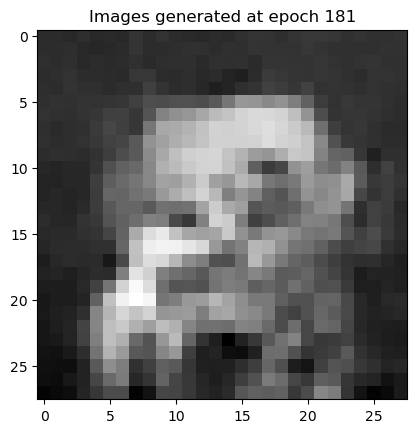

Loss at epoch 181: 0.000
Loss at epoch 182: 0.000
Loss at epoch 183: 0.000
Loss at epoch 184: 0.000
Loss at epoch 185: 0.000
Epoch 185 | step 155 Loss: 0.056880414485931396 


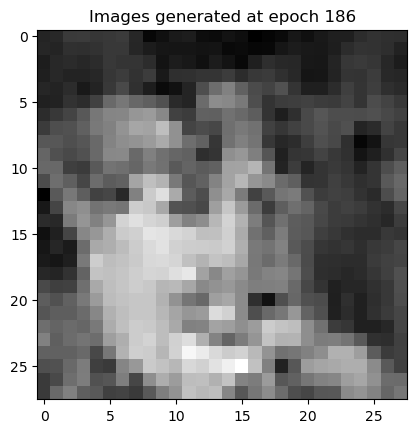

Loss at epoch 186: 0.000
Loss at epoch 187: 0.000
Loss at epoch 188: 0.000
Loss at epoch 189: 0.000
Loss at epoch 190: 0.000
Epoch 190 | step 155 Loss: 0.0600970983505249 


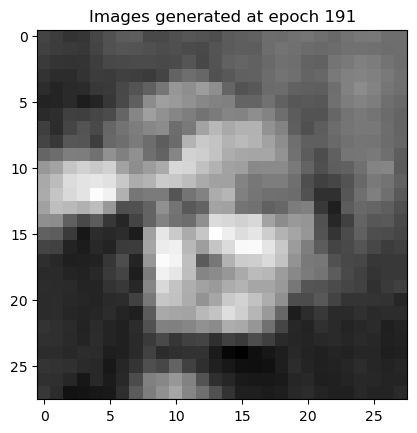

Loss at epoch 191: 0.000
Loss at epoch 192: 0.000
Loss at epoch 193: 0.000
Loss at epoch 194: 0.000
Loss at epoch 195: 0.000
Epoch 195 | step 155 Loss: 0.05311213433742523 


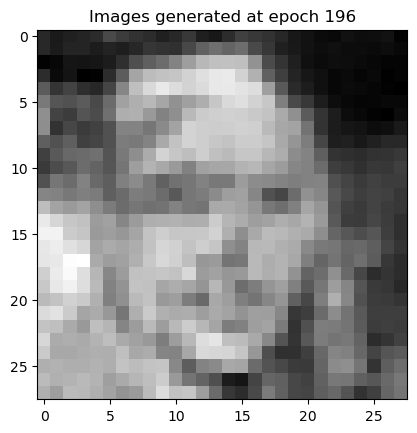

Loss at epoch 196: 0.000
Loss at epoch 197: 0.000
Loss at epoch 198: 0.000
Loss at epoch 199: 0.000
Loss at epoch 200: 0.000


In [44]:
# Diccionario para almacenar el historial de entrenamiento
train_hist = {}
train_hist['loss'] = []

# Mover el modelo a la GPU si está disponible
model.to(device)

# Inicialización del optimizador (Adam) y la función de pérdida (MSELoss)
optimizer = Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()

# Mejor pérdida inicializada como infinito
best_loss = float("inf")

# Número total de pasos de difusión
n_steps = model.n_steps

# Número de épocas de entrenamiento
epochs = EPOCH

# Fuerza de la guía generativa
ws_test = [0.0, 0.5, 2.0]

# Bucle de entrenamiento
for epoch in range(epochs):
    # Crear un DataLoader para cargar los datos de entrenamiento en lotes
    data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    # Ajustar la tasa de aprendizaje según la época actual
    optimizer.param_groups[0]['lr'] = lr * (1 - epoch / epochs)
    
    # Pérdida total para la época actual
    epoch_loss = 0.0
    
    # Iterar sobre los lotes de datos
    for step, batch in enumerate(data_loader):
        optimizer.zero_grad()
        
        # Transferir el lote a la GPU si está disponible
        x = batch.to(device)
        n = len(x)
        
        # Generar ruido para las imágenes y seleccionar pasos de tiempo aleatorios
        eta = torch.randn_like(x).to(device)
        t = torch.randint(0, n_steps, (n,)).to(device)
        
        # Calcular imágenes ruidosas y pérdida
        noisy_imgs = model(x, t, eta)
        eta_theta = model.backward(noisy_imgs, t.reshape(n, -1))
        loss = mse(eta_theta, eta)
        train_hist['loss'].append(loss.item())
        
        # Retropropagación y actualización de los pesos del modelo
        loss.backward()
        optimizer.step()
                
    # Acumular la pérdida total de la época actual
    epoch_loss += loss.item() * len(x) / len(data_loader.dataset)

    # Verificar si el número de época actual es divisible por 5
    if epoch % 5 == 0:
        # Imprimir información sobre la época y la pérdida del lote actual
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
    
        # Generar nuevas imágenes utilizando el modelo entrenado
        img = generate_new_images(model, n_samples=4, device=device)
    
        # Mostrar visualmente las imágenes generadas
        show_tensor_image(img.detach().cpu(), False)
    
        # Establecer el título de la figura que muestra las imágenes generadas
        plt.title(f"Images generated at epoch {epoch + 1}")
    
        # Mostrar la figura que contiene las imágenes generadas
        plt.show()
    
    # Crear un registro de pérdida al final de cada época
    log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"
    
    # Almacenar el modelo si la pérdida actual es la mejor hasta ahora
    if best_loss > epoch_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), os.path.join(save_dir, 'testing.pt'))
        log_string += " --> Best model ever (stored)"
    
    # Imprimir el registro de pérdida al final de cada época
    print(log_string)
    


In [45]:
# Guardar los pesos entrenados del modelo en un archivo
# El método `state_dict()` devuelve un diccionario que contiene todos los pesos entrenados del modelo
# El archivo se guarda en el directorio especificado (`save_dir`) con el nombre especificado ('32_relu_diffusion_model_200_epoch.pt')
torch.save(model.state_dict(), os.path.join(save_dir, '32_relu_diffusion_model_200_epoch.pt'))


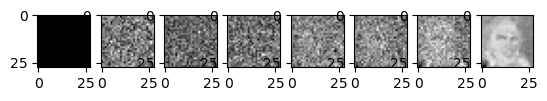

In [46]:
# Cargar los pesos del modelo previamente guardados
# El método `load_state_dict()` carga los pesos del modelo desde el archivo especificado
model.load_state_dict(torch.load(os.path.join(save_dir, '32_relu_diffusion_model_200_epoch.pt')))

# Generar nuevas imágenes utilizando el modelo cargado para el proceso de eliminación de ruido
imgs = generate_new_images(model, n_samples=1, device=device, process=True)

# Mostrar las imágenes generadas
for idx, img in enumerate(imgs):
    plt.subplot(1, 7 + 1, idx + 1)
    show_tensor_image(img.detach().cpu(), False)


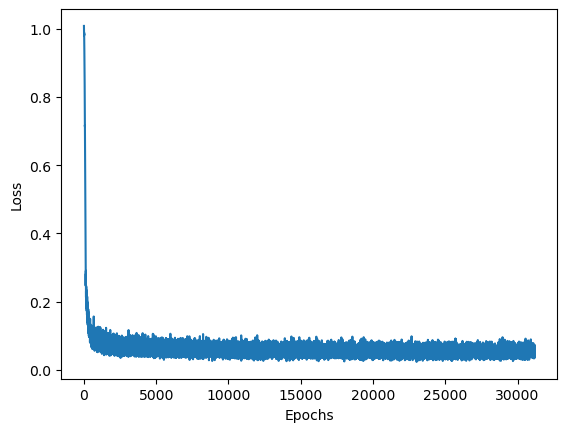

In [47]:
fig = plt.figure()
plt.plot(train_hist['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Saving 00001.png
Saving 00002.png
Saving 00003.png
Saving 00004.png
Saving 00005.png
Saving 00006.png
Saving 00007.png
Saving 00008.png
Saving 00009.png
Saving 00010.png


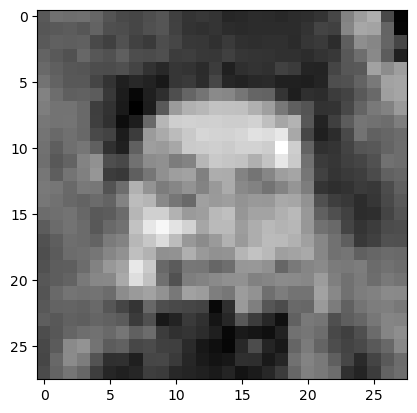

In [48]:
# Decorador @torch.no_grad() para desactivar el cálculo de gradientes
@torch.no_grad()
def plot_result_image():
    # Número de imágenes a generar
    num_images = 10
    
    # Crear la carpeta "images" si no existe
    os.makedirs('./images', exist_ok=True)
    
    # Generar y guardar las imágenes
    for j in range(num_images):
        # Generar una imagen utilizando el modelo y el dispositivo especificados
        image = generate_new_images(model, n_samples=1, device=device)
        
        # Mostrar la imagen y guardarla en un archivo PNG
        img = show_tensor_image(image.detach().cpu(), False)
        path = os.path.join(f'./images/{j+1:05d}.png')
        print(f'Saving {j+1:05d}.png')
        save_image(img, path, normalize=True)

# Llamar a la función para generar y guardar las imágenes
plot_result_image()
